# Tobig's 19기 2주차 Optimization 과제

# Gradient Descent 구현하기

### 1)"..."표시되어 있는 빈 칸을 채워주세요
### 2)강의내용과 코드에 대해 공부한 내용을 마크마운 또는 주석으로 설명해주세요

## 데이터

In [24]:
import pandas as pd
import numpy as np
import random

In [25]:
data = pd.read_csv('assignment_2.csv')
data.head()

,Label,bias,experience,salary
0,1,1,0.7,48000
1,0,1,1.9,48000
2,1,1,2.5,60000
3,0,1,4.2,63000
4,0,1,6.0,76000


## Train Test 데이터 나누기

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0], test_size = 0.25, random_state = 0)

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((150, 3), (50, 3), (150,), (50,))

## Scaling

experience와 salary의 단위, 평균, 분산이 크게 차이나므로 scaler를 사용해 단위를 맞춰줍니다. 

bias를 bias_train으로 남겨둔 후 (reset_index) 나머지 column에 대해 scaler 적용

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
bias_train = X_train["bias"]
bias_train = bias_train.reset_index()["bias"]
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_train["bias"] = bias_train
X_train.head()

,bias,experience,salary
0,1,0.187893,-1.143335
1,1,1.185555,0.043974
2,1,-0.310938,-0.351795
3,1,-1.629277,-1.341220
4,1,-1.308600,0.043974


이때 scaler는 X_train에 fit 해주시고, fit한 scaler를 X_test에 적용시켜줍니다.  
똑같이 X_test에다 fit하면 안돼요!

In [30]:
bias_test = X_test["bias"]
bias_test = bias_test.reset_index()["bias"]
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
X_test["bias"] = bias_test
X_test.head()

,bias,experience,salary
0,1,-1.344231,-0.615642
1,1,0.508570,0.307821
2,1,-0.310938,0.571667
3,1,1.363709,1.956862
4,1,-0.987923,-0.747565


In [31]:
# parameter 개수
N = len(X_train.loc[0])

In [32]:
# 초기 parameter들을 임의로 설정해줍니다.
parameters = np.array([random.random() for i in range(N)])
random_parameters = parameters.copy()
parameters

array([0.5419583 , 0.1440925 , 0.84461645])

### * LaTeX   

Jupyter Notebook은 LaTeX 문법으로 수식 입력을 지원하고 있습니다.  
LaTeX문법으로 아래의 수식을 완성해주세요  
http://triki.net/apps/3466  
https://jjycjnmath.tistory.com/117

## Dot product
## $z = X_i \theta$

In [33]:
def dot_product(X, parameters):
    z = 0
    for i in range(len(parameters)):
        z += parameters[i]*X[i]
    return z

In [34]:
dot_product(X_train.iloc[1], parameters)

0.749929427508297

## Logistic Function

## $p = {1 \over {1+e^{-X_i \theta}}}$

In [41]:
def logistic(X, parameters):
    z = dot_product(X, parameters)
    p = 1/(1+np.exp(-z))    
    return p

In [42]:
logistic(X_train.iloc[1], parameters)

0.679163321588309

## Object function

Object Function : 목적함수는 Gradient Descent를 통해 최적화 하고자 하는 함수입니다.  
<br>
선형 회귀의 목적함수
## $l(\theta) = \frac{1}{2}\Sigma(y_i - \theta^{T}X_i)^2$  
참고) $\hat{y_i} = \theta^{T}X_i$
  
로지스틱 회귀의 목적함수를 작성해주세요  
(선형 회귀의 목적함수처럼 강의에 나온대로 작성해주세요. 평균을 고려하는 것은 뒤에 코드에서 수행합니다)
## $l(p) = -\sum\{y_iX_i^T\theta-\log(1+e^{X_i^T\theta})\}$ 

회귀에 대해서는 mse를 계산

In [43]:
def mse_i(X, y, parameters):
    y_hat = dot_product(X, parameters)
    loss = (y-y_hat)**2
    return loss

분류에 대한 logistic은  cross entropy를 계산

In [44]:
def minus_log_cross_entropy_i(X, y, parameters):
    p = logistic(X, parameters)
    loss = -(y*np.log(p)+(1-y)*np.log(1-p))
    return loss

In [45]:
def batch_loss(X_set, y_set, parameters, loss_function, n): #n:현재 배치의 데이터 수
    loss = 0
    for i in range(X_set.shape[0]):
        X = X_set.iloc[i,:]
        y = y_set.iloc[i]
        loss += loss_function(X, y, parameters)
    loss /= n #loss 평균값으로 계산
    return loss

In [46]:
batch_loss(X_test, y_test, parameters, minus_log_cross_entropy_i, len(X_test))

1.1886623578851756

## Gradient
위의 선형회귀의 목적함수 $l(\theta)$와 로지스틱회귀의 목적함수 $l(p)$의 gradient를 작성해주세요  
(위의 목적함수를 참고해서 작성해주세요 = 평균을 고려하는 것은 뒤에 코드에서 수행합니다)

## ${\partial\over{\partial \theta_j}}l(\theta)= - \sum x_{ij}({y_i - \theta^{T}x_{ij}})$
## ${\partial\over{\partial \theta_j}}l(p)=-\sum {(y_i-p_i)x_{ij}}$

In [47]:
def get_gradient_ij(X, y, parameters, j, model):
    if model == 'linear':
        y_hat = dot_product(X, parameters)
        gradient =  -(y-y_hat)*X[j]
    else:
        p = logistic(X, parameters)
        gradient = -(y-p)*X[j]
    return gradient

In [48]:
get_gradient_ij(X_train.iloc[0,:], y_train.iloc[0], parameters, 1, 'logistic')

-0.11233783981883894

## Batch Gradient
하나의 배치 (X_set, y_set)에 대해 기울기를 구하는 코드를 작성해주세요

In [50]:
def batch_gradient(X_set, y_set, parameters, model):
    gradients = [0 for _ in range(len(parameters))]
    
    for i in range(X_set.shape[0]):
        X = X_set.iloc[i,:]
        y = y_set.iloc[i]
        for j in range(len(parameters)):
            gradients[j] += get_gradient_ij(X, y, parameters, j, model)
    
    return gradients

In [51]:
gradients1 = batch_gradient(X_train, y_train, parameters, 'logistic')
gradients1

[49.30663861020709, 5.1648101155080495, 42.38781602149261]

## mini-batch
인덱스로 미니 배치 나누기

In [56]:
def batch_idx(X_train, batch_size):
    N = len(X_train)
    nb = (N // batch_size)+1 #number of batch
    idx = np.array([i for i in range(N)])
    idx_list = [idx[i*batch_size:(i+1)*batch_size] for i in range(nb) if len(idx[i*batch_size:(i+1)*batch_size]) != 0]
    return idx_list

batch_idx 함수는 지정한 batch_size에 의해 결정된다. batch_size는 parameter를 업데이트할 때 하나의 batch를 구성하는 크기이다. 예를 들어, 100개의 데이터셋을 batch_size=20으로 나누고자 한다면 nb는 5가 되며, batch_idx는 하나의 batch 당 20개씩의 idx를 할당해준다.

## Update Parameters
기울기를 갱신하는 코드를 작성해주세요  
(loss와 마찬가지로 기울기를 갱신할 때 배치 사이즈를 고려해 평균으로 갱신해주세요)

In [52]:
def step(parameters, gradients, learning_rate, n): #n:현재 배치의 데이터 수
    for i in range(len(parameters)):
        gradients[i] *= (1/n)*learning_rate
    
    parameters -= gradients
    return parameters

In [53]:
step(parameters, gradients1, 0.01, len(X_train))

array([0.53867119, 0.14374818, 0.84179059])

## Gradient Descent
위에서 작성한 함수들을 조합해서 경사하강법 함수를 완성해주세요

- learning_rate: 학습률  
- tolerance: Step이 너무 작아서 더 이상의 학습이 무의미할 때 학습을 멈추는 조건  
- batch: 기울기를 1번 갱신할 때 사용하는 데이터셋  
- epoch: 전체 데이터셋을 1회 거치는 과정
- num_epoch: epoch의 반복 횟수
<br>

- BGD: 1iteration에 모든 데이터셋 사용  
- SGD: 1iteration에 1개의 데이터셋 사용
- MGD: 1iteration에 데이터셋의 일부(batch size) 사용 
<br>

batch_size에 따른 경사하강법의 종류를 적어주세요  
- batch_size=1 -> SGD
- batch_size=k -> MGD
- batch_size=whole -> BGD 

In [57]:
def gradient_descent(X_train, y_train, learning_rate = 0.1, num_epoch = 1000, tolerance = 0.00001, model = 'logistic', batch_size = 16):
    stopper = False
    
    N = len(X_train.iloc[0])
    parameters = np.random.rand(N)
    loss_function = minus_log_cross_entropy_i if model == 'logistic' else mse_i
    loss = 999
    batch_idx_list = batch_idx(X_train, batch_size)
    
    for epoch in range(num_epoch):
        if stopper:
            break
        for idx in batch_idx_list:
            X_batch = X_train.iloc[idx,]
            y_batch = y_train.iloc[idx]
            gradients = batch_gradient(X_batch, y_batch, parameters, loss_function)
            parameters = step(parameters, gradients, learning_rate, X_batch.shape[0])
            new_loss = batch_loss(X_batch, y_batch, parameters, loss_function, len(X_batch))
            
            #중단 조건
            if abs(new_loss - loss) < tolerance:
                stopper = True
                break
            loss = new_loss
        
        #100epoch마다 학습 상태 출력
        if epoch%100 == 0: #출력이 길게 나오면 check point를 수정해도 됩니다.
            print(f"epoch: {epoch}  loss: {new_loss}  params: {parameters}  gradients: {gradients}")
    
    return parameters

## Implement
경사하강법 함수를 이용해 최적의 모수 찾아보세요. 학습을 진행할 때, Hyper Parameter를 바꿔가면서 학습시켜보세요.

## Logistic Regression

In [58]:
new_param_bgd = gradient_descent(X_train, y_train, batch_size=150)
new_param_bgd

epoch: 0  loss: 0.8646210444928115  params: [0.64014049 0.26495517 0.03083322]  gradients: [0.03801789769227142, -0.0056203442942026035, 0.014573903419602014]
epoch: 100  loss: 0.44750024104882413  params: [-0.80608134  0.92149363 -0.84605252]  gradients: [0.004268562220190244, -0.006073304116325488, 0.006070757031240776]
epoch: 200  loss: 0.38900553080069517  params: [-1.03898236  1.43609504 -1.35179677]  gradients: [0.0013656445924577869, -0.0043603289077998025, 0.004254710009913688]
epoch: 300  loss: 0.359874068748774  params: [-1.14612429  1.81416567 -1.71960892]  gradients: [0.0008872082072934318, -0.003295428653871795, 0.0031956465954168112]
epoch: 400  loss: 0.3426248861159018  params: [-1.22507023  2.10678761 -2.00252433]  gradients: [0.0007115551142739932, -0.0026098766826233816, 0.002515604291925661]
epoch: 500  loss: 0.3314739498819391  params: [-1.29028736  2.34259423 -2.22921715]  gradients: [0.0005998451005386819, -0.002137834172971052, 0.002049863331213663]
epoch: 600  l

array([-1.5047218 ,  3.07928818, -2.92973085])

In [59]:
new_param_sgd = gradient_descent(X_train, y_train, batch_size=1)
new_param_sgd

epoch: 0  loss: 0.27757511205059343  params: [-0.87450142  1.10017728 -1.22782171]  gradients: [0.025072328889904794, 0.01364438536276866, 0.017640658482040387]
epoch: 100  loss: 0.07736670967107358  params: [-1.93032573  4.17501964 -4.06769125]  gradients: [0.007538542937474584, 0.004102482276949418, 0.005304049017390329]
epoch: 200  loss: 0.07736266552120513  params: [-1.9303681   4.1751431  -4.06780374]  gradients: [0.007538159521773053, 0.004102273621757919, 0.005303779249652475]
epoch: 300  loss: 0.07736266518361716  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.007538159489767122, 0.004102273604340261, 0.005303779227133398]
epoch: 400  loss: 0.07736266518359017  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.007538159489764571, 0.004102273604338872, 0.005303779227131603]
epoch: 500  loss: 0.07736266518359017  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.007538159489764571, 0.004102273604338872, 0.005303779227131603]
epoch: 600  loss: 0

array([-1.9303681 ,  4.17514311, -4.06780375])

In [60]:
new_param_mgd = gradient_descent(X_train, y_train, batch_size=64)
new_param_mgd

epoch: 0  loss: 0.9848269146503327  params: [0.27366436 0.15920845 0.57235697]  gradients: [0.028845440173751565, 0.01949041680207504, 0.04753883396119142]
epoch: 100  loss: 0.37988599491077024  params: [-1.12335755  1.71012245 -1.68618057]  gradients: [0.0010670132066451217, -0.0008857394049631999, 0.006892274290416473]
epoch: 200  loss: 0.3333194441405646  params: [-1.36856546  2.4933683  -2.42125609]  gradients: [0.002353819937843438, -0.0001595197627143443, 0.0037802966152524816]
epoch: 300  loss: 0.3157985713406319  params: [-1.52936367  2.9537505  -2.8505155 ]  gradients: [0.0030803934835322705, 0.00021699015388285507, 0.002471673740807647]
epoch: 400  loss: 0.30703256634429366  params: [-1.64255607  3.26417235 -3.13839461]  gradients: [0.0035526597893741807, 0.00044956502947172397, 0.00174745684360451]
epoch: 500  loss: 0.30197188648892886  params: [-1.72608336  3.48815487 -3.34527247]  gradients: [0.0038834826603314273, 0.000606907539731998, 0.0012890825401295988]
epoch: 600  l

array([-1.9344102 ,  4.03314305, -3.84561011])

### Predict Label

In [61]:
y_predict = []
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:], new_param_bgd)
    if p> 0.5 :
        y_predict.append(1)
    else :
        y_predict.append(0)
y_predict_random = []
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:], random_parameters)
    if p> 0.5 :
        y_predict_random.append(1)
    else :
        y_predict_random.append(0)

### Confusion Matrix

In [62]:
from sklearn.metrics import *

In [63]:
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
confusion_matrix(y_test, y_predict)

array([[38,  2],
       [ 4,  6]], dtype=int64)

In [64]:
accuracy = (tp+tn) / (tp+fn+fp+tn)
print("accuracy:",accuracy)

accuracy: 0.88


## Linear regression
### $y = 0.5 + 2.7x$

### Data

In [65]:
raw_X = np.random.rand(150)
y = 2.7*raw_X + 0.5 + np.random.randn(150)

In [66]:
tmp = np.array([1 for _ in range(150)])
X = np.vstack((tmp, raw_X)).T
X = pd.DataFrame(X)
y = pd.Series(y)

### Estimation

In [67]:
#정규방정식
theta = np.linalg.inv(np.dot(X.T,X)).dot(X.T).dot(y)
theta

array([0.23705992, 3.10188496])

In [73]:
#경사하강법
new_param = gradient_descent(X, y, model = 'linear',learning_rate = 0.00001)
new_param

epoch: 0  loss: 1.491945464086661  params: [0.59134727 0.05917728]  gradients: [-8.290310681202226e-06, -4.7269193794664e-06]
epoch: 100  loss: 1.463335597701071  params: [0.60324178 0.06780744]  gradients: [-8.25510530917736e-06, -4.7108632560427555e-06]
epoch: 200  loss: 1.4352979617623098  params: [0.61509936 0.07641692]  gradients: [-8.220173935155796e-06, -4.69493925646289e-06]
epoch: 300  loss: 1.4078275986024495  params: [0.62692031 0.0850059 ]  gradients: [-8.185517343980381e-06, -4.6791479092767145e-06]
epoch: 400  loss: 1.3809196077357748  params: [0.63870493 0.09357456]  gradients: [-8.1511362066012e-06, -4.663489679004689e-06]
epoch: 500  loss: 1.3545691460249334  params: [0.65045351 0.10212307]  gradients: [-8.117031083070534e-06, -4.6479649677416475e-06]
epoch: 600  loss: 1.3287714278077534  params: [0.66216638 0.11065162]  gradients: [-8.08320242554212e-06, -4.63257411677107e-06]
epoch: 700  loss: 1.303521724986076  params: [0.67384381 0.11916038]  gradients: [-8.0496505

array([0.70855107, 0.14448532])

In [74]:
y_hat_NE = theta.dot(X.T)
y_hat_GD = new_param.dot(X.T)

### Visualization
시각화를 통해 정규방정식과 경사하강법을 통한 선형회귀를 비교해보세요  
(밑의 코드를 실행만 시키면 됩니다. 추가 코드 x)

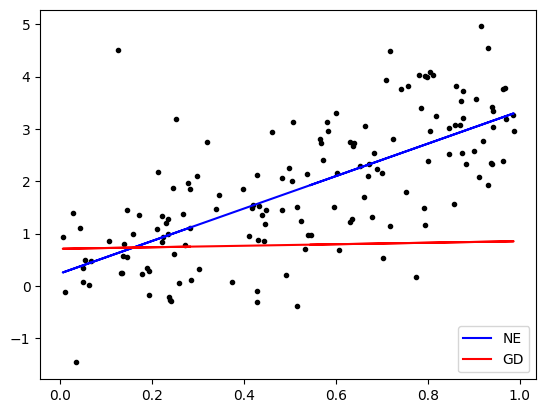

In [75]:
import matplotlib.pyplot as plt
plt.plot(X.iloc[:,1], y, '.k') #산점도
plt.plot(X.iloc[:,1], y_hat_NE, '-b', label = 'NE') #정규방정식
plt.plot(X.iloc[:,1], y_hat_GD, '-r', label = 'GD') #경사하강법
plt.legend()
plt.show()